In [5]:
import os, yaml, sys
import numpy as np
import torch
import h5py
from torchvision import models
from scipy.spatial.distance import squareform
import timm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import create_RDM, get_device, decode_matlab_strings
device = get_device()

17:53:08 - device being used: mps


In [6]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    monkey_name: str = 'paul' 
    date: str = '230204'
    model_name: str = 'vit_l_16'
    img_size: int = 384
cfg = Cfg()

In [8]:
from general_utils.utils import get_upsampling_indices, print_wise, autocorr_mat, get_lagplot
from einops import reduce
from einops.einops import EinopsError
class BrainAreas:
    def __init__(self, monkey_name: str):
        self.monkey_name = monkey_name
        with open("../../brain_areas.yaml", "r") as f:
            config = yaml.safe_load(f)
        try:
            self.areas_dict = config[self.monkey_name]
        except KeyError:
            raise KeyError(f"Monkey '{self.monkey_name}' not found.", f"Supported monkeys {list(config.keys())}") from None
        # end try:
    # EOF
    def get_monkey_name(self):
        return self.monkey_name
    # EOF
    def get_areas_dict(self):
        return self.areas_dict
    # EOF
    def slice_brain_area(self, rasters, brain_area_name):
        if rasters.shape[0] < self.areas_dict["n_chan"]:
            raise ValueError(f"Rasters of shape {rasters.shape} doesn't match the original number of channels ({self.areas_dict["n_chan"]}).")
        # end if rasters.shape[0] < self.areas_dict["n_chan"]:

        try:
            target_brain_area = self.areas_dict[brain_area_name]
        except KeyError:
            raise KeyError(f"Brain area '{brain_area_name}' not found for monkey '{self.monkey_name}'.", f"Supported brain areas: {list(self.areas_dict.keys())}") from None
        # end try:
        brain_area_response = []
        for lims in target_brain_area:
            start, end = lims
            brain_area_response.append(rasters[start:end, ...])
        # end for lims in target_brain_area:
        brain_area_response = np.concatenate(brain_area_response)
        return brain_area_response
    # EOF
# EOC


def bin_signal(time_series, new_fs):
    len_avg_window = time_series.fs /new_fs
    n_timepts = len(time_series)
    bins = np.round(np.arange(0, n_timepts, len_avg_window)).astype(int)  # bins the target trial with the required resolution, convert to int for later indexing
    if bins[-1] != n_timepts:
        bins = np.append(bins, int(n_timepts))  # adds the last time bin
    return bins
# EOF

def smooth_signal(time_series, bins):
    smoothed_signal = []
    
    for idx_bin, bin_start in enumerate(bins[:-1]): # the last el in bin is just the end of the trial, that's why the [:-1] indexing
        bin_end = bins[idx_bin + 1]
        curr_chunk = time_series[bin_start:bin_end]  # slices the current chunk
        curr_avg_chunk = np.mean(curr_chunk, axis=1)  # computes the mean firing rate over the chunk
        smoothed_signal.append(curr_avg_chunk)    
    # end for idx, bin_start in enumerate(bins[:-1]):
    smoothed_signal = np.stack(smoothed_signal, axis=1) # stacks time in the columns
    return smoothed_signal
# EOF


class TimeSeries:
    def __init__(self, array: np.ndarray, fs: float):
        self.array = array
        self.fs = fs
    # EOF

    # --- GETTERS ---
    def get_fs(self):
        return self.fs
    # EOF
    def get_duration_ms(self):
        return len(self) * 1000/self.fs 
    # EOF
    def get_duration_s(self):
        return len(self) / self.fs
    # EOF
    def get_array(self):
        return self.array
    # EOF

    # --- SETTERS ---
    def set_fs(self, new_fs):
        self.fs = new_fs
    # EOF
    def set_array(self, array):
        if type(array) != np.ndarray:
            raise TypeError(f"Type {type(array)} is not supported to be a TimeSeries.array, choose np.ndarray")
        # end if type(array) != np.ndarray:
        self.array = array
    # EOF

    # --- OTHER METHODS ---
    def __len__(self):
        """Number of time points."""
        return self.array.shape[1]
    # EOF
    def __iter__(self):
        """Iterate over time points, yielding (neurons, trials)."""
        for t in range(self.array.shape[1]):
            yield self.array[:, t, ...]
    # EOF
    def __getitem__(self, t):
        """Return data at time index t: (neurons, trials)."""
        return self.array[:, t, ...]
    def trial_avg(self):
        try:
            trial_avg = reduce(self.array, 'neurons time trials -> neurons time', 'mean')
            return trial_avg
        except EinopsError:
            raise EinopsError(f"Array of size {self.array.shape} doesn't have the trial dimension (2nd dimension).") from None            
    # EOF
    def neurons_avg(self):
        neurons_avg = reduce(self.get_array(), 'neurons time ... -> 1 time ...', 'mean')
        return neurons_avg
    # EOF
    def overall_avg(self):
        overall_avg = reduce(self.get_array(), 'neurons time ... -> time', 'mean')
        return overall_avg
    # EOF
    def resample(self, new_fs):
        if new_fs < self.fs: # smoothing
            bins = bin_signal(self, new_fs)
            new_array = smooth_signal(self, bins)
        elif new_fs > self.fs: # upsampling
            upsampling_indices = get_upsampling_indices(len(self), self.fs, new_fs)
            new_array = self.array[:,upsampling_indices, ...]
        # end if new_fs < self.fs:
        # in-place modifications
        self.set_array(new_array) 
        self.set_fs(new_fs) # updates the fs
    # EOF
    def multivariate_autocorr(self, metric: str ='correlation'):
        ac_mat = autocorr_mat(self.array, metric)
        ac_line = get_lagplot(ac_mat)
        return ac_mat, ac_line
    # EOF
    def lagged_corr(self, other: "TimeSeries", metric: str = 'correlation'):
        ac_mat = autocorr_mat(self.array, data2=other.array, metric=metric)
        return ac_mat 
    # EOF
# EOC

In [9]:
rasters_path = f"{paths['livingstone_lab']}/tiziano/data/{cfg.monkey_name}_natraster{cfg.date}.mat"
with h5py.File(rasters_path, "r") as f:
    rasters = f["natraster"][:]      
rasters = rasters.transpose(2, 1, 0)
print(rasters.shape) # channels, time, trials

(383, 400, 4377)


In [10]:
ts = TimeSeries(rasters[:20, :, :30], 1000)


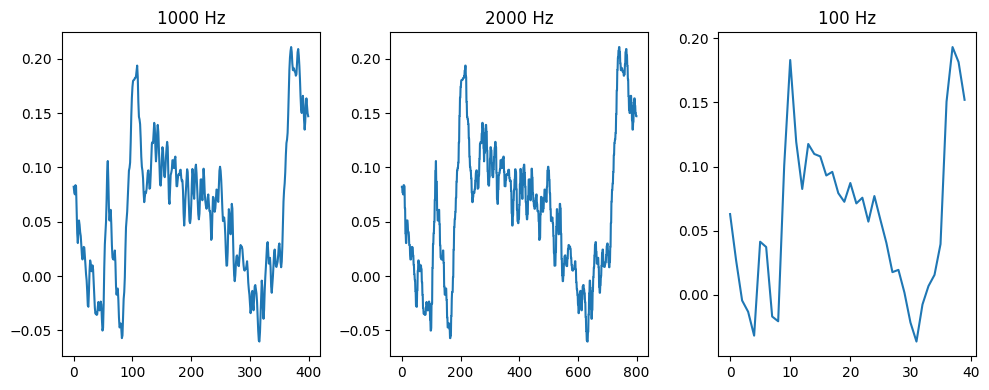

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ts = TimeSeries(rasters[:20, :, :30], 1000)
ax[0].plot(ts.overall_avg())
ax[0].set_title(f"{ts.fs} Hz")
ts.resample(2000)
ax[1].plot(ts.overall_avg())
ax[1].set_title(f"{ts.fs} Hz")
ts.resample(100)
ax[2].plot(ts.overall_avg())
ax[2].set_title(f"{ts.fs} Hz")

plt.tight_layout()

In [14]:
from general_utils.utils import create_RDM, spearman
from scipy.spatial.distance import squareform

def check_RDM_type(RDM_type: str):
    if RDM_type not in ("signal", "model"):
        raise ValueError(f"{RDM_type} is not a supported RDM_type, you can choose either 'signal' or 'model'")
    # end if RDM_type != "signal" & RDM_type!="model":
# EOF
def check_attributes(obj, *attrs):
    missing = [
        attr for attr in attrs
        if not hasattr(obj, attr) or getattr(obj, attr) is None
    ]
    if missing:
        raise AttributeError(
            f"{obj.__class__.__name__} has unset attributes: {missing}"
        )


class RSA:
    def __init__(
            self, 
            signal_RDM_metric: str, 
            model_RDM_metric: str=None, 
            RSA_metric: str='correlation', 
            signal_RDM: np.ndarray = None, 
            model_RDM: np.ndarray = None,
            ):
        self.signal_RDM_metric = signal_RDM_metric
        if model_RDM_metric is None:
            self.model_RDM_metric = signal_RDM_metric
        else:
            self.model_RDM_metric = model_RDM_metric
        # end if model_RDM_metric is None:
        self.RSA_metric = RSA_metric
        self.signal_RDM = signal_RDM
        self.model_RDM = model_RDM
    # EOF
    
    # --- GETTERS ---
    def get_RDM_metric(self, RDM_type):
        check_RDM_type(RDM_type)
        attr = f"{RDM_type}_RDM_metric"
        return getattr(self, attr)
    # EOF
    def get_RSA_metric(self):
        return self.RSA_metric
    # EOF
    def get_RDM(self, RDM_type: str):
        check_RDM_type(RDM_type)
        attr = f"{RDM_type}_RDM"
        return getattr(self, attr)
        #raise ValueError("Supported RDM types are 'signal' or 'model'")
        # end if RDM_type == "signal":
    # EOF

    # --- SETTERS ---
    def set_RDM_metrics(self, metric: str, RDM_type: str):
        check_RDM_type(RDM_type)
        attr = f"{RDM_type}_RDM_metric"
        setattr(self, attr, metric)
    # EOF
    def set_RDM(self, RDM: np.ndarray, RDM_type: str):
        check_RDM_type(RDM_type)
        if RDM_type == "signal":
            self.signal_RDM = RDM
        elif RDM_type == "model":
            self.model_RDM = RDM
        else:
            raise ValueError("Supported RDM types are 'signal' or 'model'")
        # end if RDM_type == "signal":
    # EOF
    
    # --- OTHER METHODS ---
    def compute_RDM(self, data: np.ndarray, RDM_type: str):
        check_RDM_type(RDM_type)
        check_attributes(self, f"{RDM_type}_RDM_metric")
        metric = getattr(self, f"{RDM_type}_RDM_metric")
        attr = f"{RDM_type}_RDM"
        RDM = create_RDM(data, metric)
        setattr(self, attr, RDM)
        return RDM
    # EOF
    def compute_both_RDMs(self, signal: np.ndarray, model: np.ndarray):
        check_attributes(self, "signal_RDM_metric", "model_RDM_metric")
        self.compute_RDM(signal, "signal")
        self.compute_RDM(model, "model")
    # EOF
    def compute_RSA(self): 
        check_attributes(self, "signal_RDM_metric", "model_RDM_metric", "RSA_metric", "signal_RDM", "model_RDM")
        if self.RSA_metric == 'correlation':
            similarity = np.corrcoef(self.signal_RDM, self.model_RDM)[0,1]
        elif self.RSA_metric == 'spearman':
            similarity = spearman(self.signal_RDM, self.model_RDM)
        else:
            raise TypeError(f"{self.RSA_metric} not supported.")
        # if self.RSA_metric == 'correlation':
        self.similarity = similarity
        return similarity
    # EOF
    def squareform(self, RDM_type: str):
        check_attributes(self, f"{RDM_type}_RDM")
        target_RDM = self.get_RDM(RDM_type)
        return squareform(target_RDM)
    # EOF

In [81]:
np.corrcoef([3,4,5], [4,5,6])

array([[1., 1.],
       [1., 1.]])

In [25]:
from general_utils.utils import compute_dRSA
class dRSA(RSA):
    def __init__(
            self, 
            signal_RDM_metric: str, 
            model_RDM_metric: str=None, 
            RSA_metric: str='correlation', 
            signal_RDM_timeseries: TimeSeries = None, 
            model_RDM_timeseries: TimeSeries = None,
            model_RDM_static: np.ndarray = None,
            ):
        super().__init__(signal_RDM_metric, model_RDM_metric, RSA_metric)
        self.signal_RDM_timeseries = signal_RDM_timeseries
        self.model_RDM_timeseries = model_RDM_timeseries
        self.model_RDM_static = model_RDM_static
    # EOF

    # --- GETTERS ---
    def get_RDM_timeseries(self, RDM_type: str):
        check_RDM_type(RDM_type)
        attr = f"{RDM_type}_RDM_timeseries"
        getattr(self, attr)
    # EOF
    
    # --- SETTERS ---
    def set_RDM_timeseries(self, RDM_timeseries: TimeSeries, RDM_type: str):
        check_RDM_type(RDM_type)
        attr = f"{RDM_type}_RDM_timeseries"
        setattr(self, attr, RDM_timeseries)
    # EOF

    # --- OTHER FUNCTIONS
    def compute_RDM_timeseries(self, signal: TimeSeries, RDM_type: str):
        check_RDM_type(RDM_type)
        RSA_obj = RSA(self.signal_RDM_metric, model_RDM_metric=self.model_RDM_metric)
        RDMs_list = []
        for t_pt in signal:
            RDM = RSA_obj.compute_RDM(t_pt, RDM_type)
            RDMs_list.append(RDM)
        RDMs_list = TimeSeries(np.stack(RDMs_list, axis=1), signal.get_fs())
        attr = f"{RDM_type}_RDM_timeseries"
        setattr(self, attr, RDMs_list)
    # EOF
    def compute_both_RDM_timeseries(self, signal: TimeSeries, model: TimeSeries):
        self.compute_RDM_timeseries(signal, "signal")
        self.compute_RDM_timeseries(model, "model")
    # EOF
    def compute_dRSA(self):
        check_attributes(self, "signal_RDM_timeseries", "model_RDM_timeseries")
        self.dRSA_mat = self.signal_RDM_timeseries.lagged_corr(self.model_RDM_timeseries, self.RSA_metric)
        return self.dRSA_mat
    # EOF
    def compute_static_dRSA(self):
        check_attributes(self, "signal_RDM_timeseries", "model_RDM_static")
        static_dRSA = []
        RSA_obj = RSA(self.signal_RDM_metric, model_RDM_metric=self.model_RDM_metric, model_RDM=self.model_RDM) # compute_RDM is inherited from RSA object
        for t_pt in self.signal_RDM_timeseries:    
            RSA_obj.set_RDM(t_pt, "signal")
            similarity_t = RSA_obj.compute_RSA()
            static_dRSA.append(similarity_t)
        # end
        static_dRSA = TimeSeries(np.array(static_dRSA), self.signal_RDM_timeseries.fs)
        return static_dRSA
    # EOF
        

In [ ]:
def pearson(x, y):
    corr = np.corrcoef(x, y)[0, 1]
    return corr

In [16]:

l = "blocks.0.mlp.fc2"
feats = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_features_meanpool.npz")["arr_0"]

In [ ]:
rsa_obj = RSA('cosine')
rsa_obj.compute_both_RDMs(TimeSeries(rasters[:, :, :], 1000)[100], feats.T)
print(rsa_obj.compute_RSA())

0.13007923177670488


In [26]:
from time import time
drsa_obj = dRSA('cosine')
start = time()
drsa_obj.compute_RDM_timeseries(TimeSeries(rasters[:20, :, :1500], 1000), "signal")
end = time()
print(end- start)
# drsa_obj.compute_RDM(feats.T[:, :1500], "model")
# plt.plot(drsa_obj.compute_static_dRSA().array)

7.016717910766602
